In [1]:
%matplotlib inline

In [3]:
import fenics

import phaseflow

# Demonstrate the Stefan problem.

Define function to run the Stefan problem with Phaseflow.

In [4]:
def stefan_problem(time_step_count = 100,
        grid_size = 1000):

    T_h = 1.
    
    T_c = -0.01
    
    end_time = 0.1
                       
    stefan_number = 0.125
    
    nt = time_step_count
    
    nx = grid_size
    
    solution, mesh = phaseflow.run(
        output_dir = "output/convergence_stefan_problem/nt" + str(nt) + "/nx" + str(nx) + "/",
        prandtl_number = 1.,
        stefan_number = stefan_number,
        gravity = [0.],
        mesh = fenics.UnitIntervalMesh(grid_size),
        initial_values_expression = (
            "0.",
            "0.",
            "(" + str(T_h) + " - " + str(T_c) + ")*(x[0] <= 0.001) + " + str(T_c)),
        boundary_conditions = [
            {'subspace': 0, 'value_expression': [0.], 'degree': 3,
                 'location_expression': "near(x[0],  0.) | near(x[0],  1.)", 'method': "topological"},
            {'subspace': 2, 'value_expression': T_h, 'degree': 2, 
                 'location_expression': "near(x[0],  0.)", 'method': "topological"},
            {'subspace': 2, 'value_expression': T_c, 'degree': 2, 
                 'location_expression': "near(x[0],  1.)", 'method': "topological"}],
        temperature_of_fusion = 0.,
        regularization_smoothing_factor = 0.01,
        end_time = end_time,
        time_step_size = end_time/float(time_step_count),
        stop_when_steady = False)
        
    velocity, pressure, temperature = solution.split()
        
    return temperature
    

# Set the baseline.

First we obtain a baseline solution.

In [5]:
baseline_time_step_count = 1

baseline_grid_size = 1000

baseline_solution = stefan_problem(
        time_step_count = baseline_time_step_count,
        grid_size = baseline_grid_size)

Running Phaseflow with the following arguments:
({'nlp_max_iterations': 50, 'output_dir': 'output/convergence_stefan_problem/nt1/nx1000/', 'nlp_relative_tolerance': 1e-08, 'temperature_of_fusion': 0.0, 'nlp_absolute_tolerance': 1e-08, 'end_time': 0.1, 'steady_relative_tolerance': 0.0001, 'restart': False, 'initial_values_expression': ('0.', '0.', '(1.0 - -0.01)*(x[0] <= 0.001) + -0.01'), 'penalty_parameter': 1e-07, 'adaptive_solver_tolerance': 0.0001, 'ddT_m_B': <function run.<locals>.ddT_m_B at 0x7f600987ba60>, 'regularization_smoothing_factor': 0.01, 'heat_capacity': 1.0, 'stefan_number': 0.125, 'restart_filepath': '', 'gravity': [0.0], 'rayleigh_number': 1000000.0, 'm_B': <function run.<locals>.m_B at 0x7f602d29f730>, 'start_time': 0.0, 'time_step_size': 0.1, 'thermal_conductivity': 1.0, 'liquid_viscosity': 1.0, 'adaptive': False, 'boundary_conditions': [{'subspace': 0, 'location_expression': 'near(x[0],  0.) | near(x[0],  1.)', 'method': 'topological', 'degree': 3, 'value_expressio

and plot the temperature field

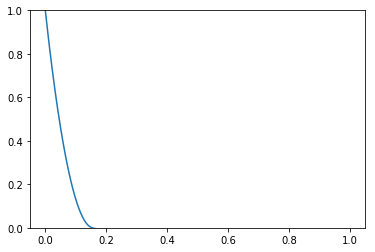

In [6]:
fenics.plot(baseline_solution)

# Converge in time.

Use a Python dict to organize the results.

In [7]:
solutions = {"nt1_nx1000": baseline_solution}

Define a function to compute new solutions and add the results to the dictionary.

In [14]:
def compute_and_append_new_solution(nt, nx, solutions):

    solution = stefan_problem(
        time_step_count = nt,
        grid_size = nx)

    solutions["nt" + str(nt) + "_nx" + str(nx)] = solution
    
    fenics.plot(solution)
    
    print(solutions.keys())
    
    return solutions

Set a constant rate of refinement so that convergence rates can be computed.

In [15]:
r = 2

To compute a convergence rate, we need three solutions. The solution with smallest time step size will be used as the "truth". Then we can compute errors for the two coarser solutions, and compute the convergence rate from these errors. We already have one solution, so we only need two more for our first estimate.

Running Phaseflow with the following arguments:
({'nlp_max_iterations': 50, 'output_dir': 'output/convergence_stefan_problem/nt2/nx1000/', 'nlp_relative_tolerance': 1e-08, 'temperature_of_fusion': 0.0, 'nlp_absolute_tolerance': 1e-08, 'end_time': 0.1, 'steady_relative_tolerance': 0.0001, 'restart': False, 'initial_values_expression': ('0.', '0.', '(1.0 - -0.01)*(x[0] <= 0.001) + -0.01'), 'penalty_parameter': 1e-07, 'adaptive_solver_tolerance': 0.0001, 'ddT_m_B': <function run.<locals>.ddT_m_B at 0x7f6001bd2730>, 'regularization_smoothing_factor': 0.01, 'heat_capacity': 1.0, 'stefan_number': 0.125, 'restart_filepath': '', 'gravity': [0.0], 'rayleigh_number': 1000000.0, 'm_B': <function run.<locals>.m_B at 0x7f6001bd2048>, 'start_time': 0.0, 'time_step_size': 0.05, 'thermal_conductivity': 1.0, 'liquid_viscosity': 1.0, 'adaptive': False, 'boundary_conditions': [{'subspace': 0, 'location_expression': 'near(x[0],  0.) | near(x[0],  1.)', 'method': 'topological', 'degree': 3, 'value_expressi

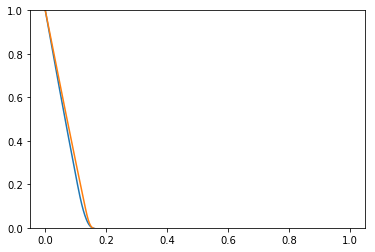

In [16]:
for i in [1, 2]:
    
    solutions = compute_and_append_new_solution(r**i*baseline_time_step_count, baseline_grid_size, solutions)

With these solutions in hand, we compute the errors with respect to the finest solution

In [17]:
errors = [fenics.errornorm(solutions["nt4_nx1000"], solutions["nt" + str(nt) + "_nx1000"], "L2") 
          for nt in [2, 1]]

print(errors)

[0.016379178527930936, 0.05659966587160091]


We compute the order of convergence as

In [18]:
import math

def compute_order(fine, coarse):
    
    return math.log(fine/coarse)/math.log(1./r)

which gives us

In [19]:
order = compute_order(errors[0], errors[1])

print(order)

1.7889305336480585


We expect a number closer to one. Perhaps we are not yet in the range of asymptotic convergence. Let's refine a few more times.

Running Phaseflow with the following arguments:
({'nlp_max_iterations': 50, 'output_dir': 'output/convergence_stefan_problem/nt8/nx1000/', 'nlp_relative_tolerance': 1e-08, 'temperature_of_fusion': 0.0, 'nlp_absolute_tolerance': 1e-08, 'end_time': 0.1, 'steady_relative_tolerance': 0.0001, 'restart': False, 'initial_values_expression': ('0.', '0.', '(1.0 - -0.01)*(x[0] <= 0.001) + -0.01'), 'penalty_parameter': 1e-07, 'adaptive_solver_tolerance': 0.0001, 'ddT_m_B': <function run.<locals>.ddT_m_B at 0x7f6007ec7378>, 'regularization_smoothing_factor': 0.01, 'heat_capacity': 1.0, 'stefan_number': 0.125, 'restart_filepath': '', 'gravity': [0.0], 'rayleigh_number': 1000000.0, 'm_B': <function run.<locals>.m_B at 0x7f6007ec7840>, 'start_time': 0.0, 'time_step_size': 0.0125, 'thermal_conductivity': 1.0, 'liquid_viscosity': 1.0, 'adaptive': False, 'boundary_conditions': [{'subspace': 0, 'location_expression': 'near(x[0],  0.) | near(x[0],  1.)', 'method': 'topological', 'degree': 3, 'value_expres

Reached end time, t = 0.1
dict_keys(['nt32_nx1000', 'nt2_nx1000', 'nt16_nx1000', 'nt4_nx1000', 'nt8_nx1000', 'nt1_nx1000'])
[0.0017721587194164208, 0.005368972096284815, 0.012792646218218975, 0.028733477269815327, 0.06742398241140399]
1.5991380854967667
1.2525969112209072
1.1674178723459812
1.2305292473207379


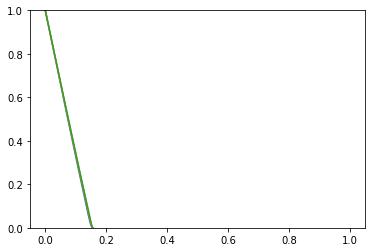

In [22]:
for i in [3, 4, 5]:
    
    solutions = compute_and_append_new_solution(r**i*baseline_time_step_count, baseline_grid_size, solutions)

In [25]:
errors = [fenics.errornorm(solutions["nt32_nx1000"], solutions["nt" + str(nt) + "_nx1000"], "L2") 
          for nt in [16, 8, 4, 2, 1]]

print(errors)

for i in range(len(errors) - 1):

    order = compute_order(errors[i], errors[i + 1])

    print(order)

[0.0017721587194164208, 0.005368972096284815, 0.012792646218218975, 0.028733477269815327, 0.06742398241140399]
1.5991380854967667
1.2525969112209072
1.1674178723459812
1.2305292473207379


and a few more refinements

Running Phaseflow with the following arguments:
({'nlp_max_iterations': 50, 'output_dir': 'output/convergence_stefan_problem/nt64/nx1000/', 'nlp_relative_tolerance': 1e-08, 'temperature_of_fusion': 0.0, 'nlp_absolute_tolerance': 1e-08, 'end_time': 0.1, 'steady_relative_tolerance': 0.0001, 'restart': False, 'initial_values_expression': ('0.', '0.', '(1.0 - -0.01)*(x[0] <= 0.001) + -0.01'), 'penalty_parameter': 1e-07, 'adaptive_solver_tolerance': 0.0001, 'ddT_m_B': <function run.<locals>.ddT_m_B at 0x7f60019a8f28>, 'regularization_smoothing_factor': 0.01, 'heat_capacity': 1.0, 'stefan_number': 0.125, 'restart_filepath': '', 'gravity': [0.0], 'rayleigh_number': 1000000.0, 'm_B': <function run.<locals>.m_B at 0x7f6007e48a60>, 'start_time': 0.0, 'time_step_size': 0.0015625, 'thermal_conductivity': 1.0, 'liquid_viscosity': 1.0, 'adaptive': False, 'boundary_conditions': [{'subspace': 0, 'location_expression': 'near(x[0],  0.) | near(x[0],  1.)', 'method': 'topological', 'degree': 3, 'value_ex

Reached time t = 0.015625
Writing solution to HDF5+XDMF
Reached time t = 0.01640625
Writing solution to HDF5+XDMF
Reached time t = 0.0171875
Writing solution to HDF5+XDMF
Reached time t = 0.017968750000000002
Writing solution to HDF5+XDMF
Reached time t = 0.018750000000000003
Writing solution to HDF5+XDMF
Reached time t = 0.01953125
Writing solution to HDF5+XDMF
Reached time t = 0.0203125
Writing solution to HDF5+XDMF
Reached time t = 0.02109375
Writing solution to HDF5+XDMF
Reached time t = 0.021875000000000002
Writing solution to HDF5+XDMF
Reached time t = 0.022656250000000003
Writing solution to HDF5+XDMF
Reached time t = 0.0234375
Writing solution to HDF5+XDMF
Reached time t = 0.02421875
Writing solution to HDF5+XDMF
Reached time t = 0.025
Writing solution to HDF5+XDMF
Reached time t = 0.025781250000000002
Writing solution to HDF5+XDMF
Reached time t = 0.026562500000000003
Writing solution to HDF5+XDMF
Reached time t = 0.02734375
Writing solution to HDF5+XDMF
Reached time t = 0.028

Writing solution to HDF5+XDMF
Reached time t = 0.000390625
Writing solution to HDF5+XDMF
Reached time t = 0.00078125
Writing solution to HDF5+XDMF
Reached time t = 0.0011718750000000002
Writing solution to HDF5+XDMF
Reached time t = 0.0015625
Writing solution to HDF5+XDMF
Reached time t = 0.001953125
Writing solution to HDF5+XDMF
Reached time t = 0.0023437500000000003
Writing solution to HDF5+XDMF
Reached time t = 0.0027343750000000003
Writing solution to HDF5+XDMF
Reached time t = 0.003125
Writing solution to HDF5+XDMF
Reached time t = 0.003515625
Writing solution to HDF5+XDMF
Reached time t = 0.00390625
Writing solution to HDF5+XDMF
Reached time t = 0.004296875
Writing solution to HDF5+XDMF
Reached time t = 0.004687500000000001
Writing solution to HDF5+XDMF
Reached time t = 0.005078125
Writing solution to HDF5+XDMF
Reached time t = 0.0054687500000000005
Writing solution to HDF5+XDMF
Reached time t = 0.005859375
Writing solution to HDF5+XDMF
Reached time t = 0.00625
Writing solution t

Reached time t = 0.053125000000000006
Writing solution to HDF5+XDMF
Reached time t = 0.053515625000000004
Writing solution to HDF5+XDMF
Reached time t = 0.05390625
Writing solution to HDF5+XDMF
Reached time t = 0.054296875
Writing solution to HDF5+XDMF
Reached time t = 0.0546875
Writing solution to HDF5+XDMF
Reached time t = 0.055078125000000006
Writing solution to HDF5+XDMF
Reached time t = 0.055468750000000004
Writing solution to HDF5+XDMF
Reached time t = 0.055859375
Writing solution to HDF5+XDMF
Reached time t = 0.05625
Writing solution to HDF5+XDMF
Reached time t = 0.056640625
Writing solution to HDF5+XDMF
Reached time t = 0.057031250000000006
Writing solution to HDF5+XDMF
Reached time t = 0.057421875000000004
Writing solution to HDF5+XDMF
Reached time t = 0.0578125
Writing solution to HDF5+XDMF
Reached time t = 0.058203125
Writing solution to HDF5+XDMF
Reached time t = 0.05859375
Writing solution to HDF5+XDMF
Reached time t = 0.058984375000000006
Writing solution to HDF5+XDMF
Rea

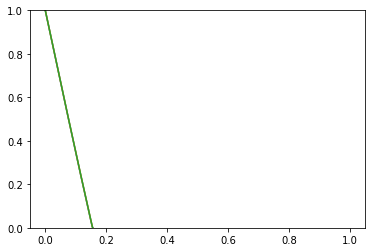

In [23]:
for i in [6, 7, 8]:
    
    solutions = compute_and_append_new_solution(r**i*baseline_time_step_count, baseline_grid_size, solutions)

In [24]:
errors = [fenics.errornorm(solutions["nt256_nx1000"], solutions["nt" + str(nt) + "_nx1000"], "L2") 
          for nt in [128, 64, 32, 16, 8, 4, 2, 1]]

print(errors)

for i in range(len(errors) - 1):

    order = compute_order(errors[i], errors[i + 1])

    print(order)

[0.00021993540992976324, 0.0006592618125444486, 0.0015388109835679556, 0.0033071926444361256, 0.006892417301235266, 0.014288290583897079, 0.030164574088385656, 0.06867572795363623]
1.5837716173418346
1.2228926108993936
1.1037910528602026
1.0594029669773142
1.051751368999705
1.078021885981231
1.1869450855224677


These results are somewhat convincing. It appears that some bias is introduced because we are using the finest solution as the truth value. Most of the results far away from the fine solution show approximately first order time accuracy.